In [1]:
# General Libraries
import re
import time
import json
import pickle
import warnings
import numpy as np
import pandas as pd
from tqdm import tqdm
from tqdm.notebook import tqdm
from collections import Counter
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Visualizations
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import graphviz
from sklearn.tree import export_graphviz

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV,
                                     StratifiedKFold)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,  
                              GradientBoostingClassifier)
from sklearn.model_selection import cross_validate
from sklearn.metrics import (ConfusionMatrixDisplay, precision_score, recall_score, f1_score)
import scipy.stats as stats
from sklearn.ensemble import IsolationForest
from pycm import ConfusionMatrix

# Imblearn
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import (SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler)
from imblearn.under_sampling import (TomekLinks, NearMiss, AllKNN,
                                     EditedNearestNeighbours, 
                                     RepeatedEditedNearestNeighbours, RandomUnderSampler) 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN

# SHAP
import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
shap.initjs()
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Model deployment
from flask import Flask
import streamlit as st

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_raw = pd.read_csv(r"C:\Users\Jamie\esk\esk_sprint2\project_sprint2\data_exploration\phl_schp_deped_clean.csv")

In [3]:
df_raw.head()

,id,object_id,school,type_of_school,region,province,legislative,division,municipality,district,barangay,total_enrollees,total_instructors,color_code,gps_source,count,school_type,color_zone,annual_per_capita_poverty_threshold_2018,poverty_incidence_among_families,population_as_of_may_2020,unemployment_rate_per_region
0,226502,10,CAA ES ANNEX,ANNEX OR EXTENSION SCHOOLS,NCR,NCR FOURTH DISTRICT,LONE,LAS PINAS CITY,CITY OF LAS PINAS,LAS PINAS CITY I,CAA,1587,14,RED,GPS PINNING (2012),1,0,HOT COLOR ZONE,28682.27409,0.697243,3861951,11.657282
1,136852,12,ACACIA ES,SCHOOL WITH NO ANNEXES,NCR,NCR THIRD DISTRICT,LONE,MALABON CITY,CITY OF MALABON,MALABON DISTRICT V,ACACIA,2681,22,RED,GPS PINNING (2012),1,1,COOL COLOR ZONE,28682.27409,2.177679,3004627,11.657282
2,136838,13,TANONG ES I,SCHOOL WITH NO ANNEXES,NCR,NCR THIRD DISTRICT,LONE,MALABON CITY,CITY OF MALABON,MALABON DISTRICT II,TAÑONG,1223,13,RED,GPS PINNING (2012),1,1,HOT COLOR ZONE,28682.27409,2.177679,3004627,11.657282
3,136850,14,TINAJEROS ES,SCHOOL WITH NO ANNEXES,NCR,NCR THIRD DISTRICT,LONE,MALABON CITY,CITY OF MALABON,MALABON DISTRICT IV,TINAJEROS,3347,30,RED,GPS PINNING (2012),1,1,HOT COLOR ZONE,28682.27409,2.177679,3004627,11.657282
4,136666,15,EULOGIO RODRIGUEZ INTEGRATED SCHOOL,SCHOOL WITH NO ANNEXES,NCR,NCR SECOND DISTRICT,LONE,MANDALUYONG CITY,CITY OF MANDALUYONG,MANDALUYONG CITY DISTRICT II,HAGDANG BATO ITAAS,2555,39,RED,GPS PINNING (2012),1,1,HOT COLOR ZONE,28682.27409,1.426553,4771371,11.657282


In [4]:
final_cols = ['school_type', 'region', 'province', 'legislative', 'division',  'total_enrollees', 'total_instructors', 'poverty_incidence_among_families',    'population_as_of_may_2020',    'unemployment_rate_per_region']

In [5]:
df_final = df_raw[final_cols]

In [6]:
df_final.head()

,school_type,region,province,legislative,division,total_enrollees,total_instructors,poverty_incidence_among_families,population_as_of_may_2020,unemployment_rate_per_region
0,0,NCR,NCR FOURTH DISTRICT,LONE,LAS PINAS CITY,1587,14,0.697243,3861951,11.657282
1,1,NCR,NCR THIRD DISTRICT,LONE,MALABON CITY,2681,22,2.177679,3004627,11.657282
2,1,NCR,NCR THIRD DISTRICT,LONE,MALABON CITY,1223,13,2.177679,3004627,11.657282
3,1,NCR,NCR THIRD DISTRICT,LONE,MALABON CITY,3347,30,2.177679,3004627,11.657282
4,1,NCR,NCR SECOND DISTRICT,LONE,MANDALUYONG CITY,2555,39,1.426553,4771371,11.657282


In [7]:
to_drop = []

for col in tqdm(df_final.columns):
    if df_final[col].dtype == 'O': # if data is an object type
        dummies = pd.get_dummies(df_final[col], prefix=col, drop_first=False) # create binary/dummy variable, using column name as the prefix
        df_final = pd.concat([df_final, dummies], axis=1) # 
        to_drop.append(col)

df_final = df_final.drop(to_drop, axis=1)
df_final.head()

  0%|          | 0/10 [00:00<?, ?it/s]

,school_type,total_enrollees,total_instructors,poverty_incidence_among_families,population_as_of_may_2020,unemployment_rate_per_region,region_ARMM,region_CAR,region_CARAGA,region_NCR,region_REGION I,region_REGION II,region_REGION III,region_REGION IVA,region_REGION IVB,region_REGION IX,region_REGION V,region_REGION VI,region_REGION VII,region_REGION VIII,region_REGION X,region_REGION XI,region_REGION XII,province_ABRA,province_AGUSAN DEL NORTE,province_AGUSAN DEL SUR,province_AKLAN,province_ALBAY,province_ANTIQUE,province_APAYAO,province_AURORA,province_BASILAN,province_BATAAN,province_BATANES,province_BATANGAS,province_BENGUET,province_BILIRAN,province_BOHOL,province_BUKIDNON,province_BULACAN,province_CAGAYAN,province_CAMARINES NORTE,province_CAMARINES SUR,province_CAMIGUIN,province_CAPIZ,province_CATANDUANES,province_CAVITE,province_CEBU,province_CITY OF COTABATO,province_COMPOSTELA VALLEY,province_DAVAO DEL NORTE,province_DAVAO DEL SUR,province_DAVAO ORIENTAL,province_DINAGAT ISLANDS,province_EASTERN SAMAR,province_GUIMARAS,province_IFUGAO,province_ILOCOS NORTE,province_ILOCOS SUR,province_ILOILO,province_ISABELA,province_KALINGA,province_LA UNION,province_LAGUNA,province_LANAO DEL NORTE,province_LANAO DEL SUR,province_LEYTE,province_MAGUINDANAO,"province_MANILA, NCR, FIRST DISTRICT",province_MARINDUQUE,province_MASBATE,province_MISAMIS OCCIDENTAL,province_MISAMIS ORIENTAL,province_MOUNTAIN PROVINCE,province_NCR FOURTH DISTRICT,province_NCR SECOND DISTRICT,province_NCR THIRD DISTRICT,province_NEGROS OCCIDENTAL,province_NEGROS ORIENTAL,province_NORTH COTABATO,province_NORTHERN SAMAR,province_NUEVA ECIJA,province_OCCIDENTAL MINDORO,province_ORIENTAL MINDORO,province_PALAWAN,province_PAMPANGA,province_PANGASINAN,province_QUEZON,province_QUIRINO,province_RIZAL,province_ROMBLON,province_SARANGANI,province_SIQUIJOR,province_SORSOGON,province_SOUTH COTABATO,province_SOUTHERN LEYTE,province_SULTAN KUDARAT,province_SULU,province_SURIGAO DEL NORTE,province_SURIGAO DEL SUR,province_TARLAC,province_TAWI-TAWI,province_WESTERN SAMAR,province_ZAMBALES,province_ZAMBOANGA DEL NORTE,province_ZAMBOANGA DEL SUR,province_ZAMBOANGA SIBUGAY,legislative_1ST,legislative_2ND,legislative_3RD,legislative_4TH,legislative_5TH,legislative_6TH,legislative_7TH,legislative_LONE,division_ABRA,division_AGUSAN DEL NORTE,division_AGUSAN DEL SUR,division_AKLAN,division_ALAMINOS CITY,division_ALBAY,division_ANGELES CITY,division_ANTIPOLO CITY,division_ANTIQUE,division_APAYAO,division_AURORA,division_BACOLOD CITY,division_BAGO CITY,division_BAGUIO CITY,division_BAIS CITY,division_BALANGA CITY,division_BASILAN,division_BATAAN,division_BATANES,division_BATANGAS,division_BATANGAS CITY,division_BAYAWAN CITY,division_BENGUET,division_BILIRAN,division_BISLIG CITY,division_BOGO CITY,division_BOHOL,division_BUKIDNON,division_BULACAN,division_BUTUAN CITY,division_CABANATUAN CITY,division_CADIZ CITY,division_CAGAYAN,division_CAGAYAN DE ORO CITY,division_CALAMBA CITY,division_CALAPAN CITY,division_CALBAYOG CITY,division_CALOOCAN CITY,division_CAMARINES NORTE,division_CAMARINES SUR,division_CAMIGUIN,division_CANDON CITY,division_CAPIZ,division_CARCAR CITY,division_CATANDUANES,division_CAUAYAN CITY,division_CAVITE,division_CAVITE CITY,division_CEBU,division_CEBU CITY,division_CITY OF NAGA CEBU,division_CITY OF SAN JUAN,division_COMPOSTELA VALLEY,division_COTABATO CITY,division_DAGUPAN CITY,division_DANAO CITY,division_DASMARINAS CITY,division_DAVAO CITY,division_DAVAO DEL NORTE,division_DAVAO DEL SUR,division_DAVAO ORIENTAL,division_DIGOS CITY,division_DINAGAT ISLAND,division_DIPOLOG CITY,division_DUMAGUETE CITY,division_EASTERN SAMAR,division_ESCALANTE CITY,division_GAPAN CITY,division_GENERAL SANTOS CITY,division_GINGOOG CITY,division_GUIHULNGAN CITY,division_GUIMARAS,division_IFUGAO,division_ILIGAN CITY,division_ILOCOS NORTE,division_ILOCOS SUR,division_ILOILO,division_ILOILO CITY,division_IRIGA CITY,division_ISABELA,division_ISLAND GARDEN CITY OF SAMAL,division_KABANKALAN 

In [8]:
# Target feature
X = df_final.drop(['school_type'], axis=1)

# Response variable
y = df_final['school_type']

In [9]:
X.head()

,total_enrollees,total_instructors,poverty_incidence_among_families,population_as_of_may_2020,unemployment_rate_per_region,region_ARMM,region_CAR,region_CARAGA,region_NCR,region_REGION I,region_REGION II,region_REGION III,region_REGION IVA,region_REGION IVB,region_REGION IX,region_REGION V,region_REGION VI,region_REGION VII,region_REGION VIII,region_REGION X,region_REGION XI,region_REGION XII,province_ABRA,province_AGUSAN DEL NORTE,province_AGUSAN DEL SUR,province_AKLAN,province_ALBAY,province_ANTIQUE,province_APAYAO,province_AURORA,province_BASILAN,province_BATAAN,province_BATANES,province_BATANGAS,province_BENGUET,province_BILIRAN,province_BOHOL,province_BUKIDNON,province_BULACAN,province_CAGAYAN,province_CAMARINES NORTE,province_CAMARINES SUR,province_CAMIGUIN,province_CAPIZ,province_CATANDUANES,province_CAVITE,province_CEBU,province_CITY OF COTABATO,province_COMPOSTELA VALLEY,province_DAVAO DEL NORTE,province_DAVAO DEL SUR,province_DAVAO ORIENTAL,province_DINAGAT ISLANDS,province_EASTERN SAMAR,province_GUIMARAS,province_IFUGAO,province_ILOCOS NORTE,province_ILOCOS SUR,province_ILOILO,province_ISABELA,province_KALINGA,province_LA UNION,province_LAGUNA,province_LANAO DEL NORTE,province_LANAO DEL SUR,province_LEYTE,province_MAGUINDANAO,"province_MANILA, NCR, FIRST DISTRICT",province_MARINDUQUE,province_MASBATE,province_MISAMIS OCCIDENTAL,province_MISAMIS ORIENTAL,province_MOUNTAIN PROVINCE,province_NCR FOURTH DISTRICT,province_NCR SECOND DISTRICT,province_NCR THIRD DISTRICT,province_NEGROS OCCIDENTAL,province_NEGROS ORIENTAL,province_NORTH COTABATO,province_NORTHERN SAMAR,province_NUEVA ECIJA,province_OCCIDENTAL MINDORO,province_ORIENTAL MINDORO,province_PALAWAN,province_PAMPANGA,province_PANGASINAN,province_QUEZON,province_QUIRINO,province_RIZAL,province_ROMBLON,province_SARANGANI,province_SIQUIJOR,province_SORSOGON,province_SOUTH COTABATO,province_SOUTHERN LEYTE,province_SULTAN KUDARAT,province_SULU,province_SURIGAO DEL NORTE,province_SURIGAO DEL SUR,province_TARLAC,province_TAWI-TAWI,province_WESTERN SAMAR,province_ZAMBALES,province_ZAMBOANGA DEL NORTE,province_ZAMBOANGA DEL SUR,province_ZAMBOANGA SIBUGAY,legislative_1ST,legislative_2ND,legislative_3RD,legislative_4TH,legislative_5TH,legislative_6TH,legislative_7TH,legislative_LONE,division_ABRA,division_AGUSAN DEL NORTE,division_AGUSAN DEL SUR,division_AKLAN,division_ALAMINOS CITY,division_ALBAY,division_ANGELES CITY,division_ANTIPOLO CITY,division_ANTIQUE,division_APAYAO,division_AURORA,division_BACOLOD CITY,division_BAGO CITY,division_BAGUIO CITY,division_BAIS CITY,division_BALANGA CITY,division_BASILAN,division_BATAAN,division_BATANES,division_BATANGAS,division_BATANGAS CITY,division_BAYAWAN CITY,division_BENGUET,division_BILIRAN,division_BISLIG CITY,division_BOGO CITY,division_BOHOL,division_BUKIDNON,division_BULACAN,division_BUTUAN CITY,division_CABANATUAN CITY,division_CADIZ CITY,division_CAGAYAN,division_CAGAYAN DE ORO CITY,division_CALAMBA CITY,division_CALAPAN CITY,division_CALBAYOG CITY,division_CALOOCAN CITY,division_CAMARINES NORTE,division_CAMARINES SUR,division_CAMIGUIN,division_CANDON CITY,division_CAPIZ,division_CARCAR CITY,division_CATANDUANES,division_CAUAYAN CITY,division_CAVITE,division_CAVITE CITY,division_CEBU,division_CEBU CITY,division_CITY OF NAGA CEBU,division_CITY OF SAN JUAN,division_COMPOSTELA VALLEY,division_COTABATO CITY,division_DAGUPAN CITY,division_DANAO CITY,division_DASMARINAS CITY,division_DAVAO CITY,division_DAVAO DEL NORTE,division_DAVAO DEL SUR,division_DAVAO ORIENTAL,division_DIGOS CITY,division_DINAGAT ISLAND,division_DIPOLOG CITY,division_DUMAGUETE CITY,division_EASTERN SAMAR,division_ESCALANTE CITY,division_GAPAN CITY,division_GENERAL SANTOS CITY,division_GINGOOG CITY,division_GUIHULNGAN CITY,division_GUIMARAS,division_IFUGAO,division_ILIGAN CITY,division_ILOCOS NORTE,division_ILOCOS SUR,division_ILOILO,division_ILOILO CITY,division_IRIGA CITY,division_ISABELA,division_ISLAND GARDEN CITY OF SAMAL,division_KABANKALAN CITY,divisio

In [10]:
y.head()

0    0
1    1
2    1
3    1
4    1
Name: school_type, dtype: int64

In [11]:
(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y, 
                                                                  random_state=11, test_size=0.25,
                                                                  stratify=y) # to maintain the number of samples for each class

In [12]:
# initialize models with default hyperparamters
models_dict = {
    'RandomForestClassifier': RandomForestClassifier(random_state=11, n_estimators= 500, max_depth=10)
}

In [13]:
def auto_ml(X, y, models_dict, scaler=None, cv=None, res_t=None):
    """Apply resampling for imbalanced data"""
    results = {} #for visualization
    results2 = {} #for tables

    # log start time
    total_start = time.time()

    for model_name, model in tqdm(models_dict.items()):
        
        ################# this portion can be edited ###############
        train_scores = []
        val_scores = []

        train_recall = []
        val_recall = []

        train_prec = []
        val_prec = []

        train_f1 = []
        val_f1 = []

        ###########################################################

        for train_index, val_index in tqdm(cv.split(X, y)):

            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply scaling
            if scaler is not None:
                X_train["population_as_of_may_2020"] = scaler.fit_transform(X_train)
                X_val["population_as_of_may_2020"] = scaler.transform(X_val)
            else:
                pass

            # Apply resampling
            if res_t is not None:
                s = time.time()
                X_train, y_train = res_t.fit_resample(X_train, y_train)
                print(f'Resampling done in {time.time() - s}')
            else:
                pass

            start_time = time.time()

            # fit
            model.fit(X_train, y_train)

            # predict
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            ################# this portion can be edited ###############

            # classification accuracy
            train_scores.append(model.score(X_train, y_train))
            val_scores.append(model.score(X_val, y_val))

            # recall
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))

            # precision
            train_prec.append(precision_score(y_train, train_preds))
            val_prec.append(precision_score(y_val, val_preds))

            # f1
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))            

            end_time = time.time()

            results[model_name] = {
                'Train Accuracy': np.round(np.mean(train_scores) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_scores) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                "Train Precision": np.round(np.mean(train_prec) * 100, 2),
                "Val Precision": np.round(np.mean(val_prec) * 100, 2),
                "Train f1": np.round(np.mean(train_f1) * 100, 2),
                "Val f1": np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }

            results2[model_name] = {
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_scores)*100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_scores)*100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall)*100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall)*100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_prec)*100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_prec)*100, 2)),
                'Train f1': '{:.2f}%'.format(np.round(np.mean(train_f1)*100, 2)),
                'Val f1': '{:.2f}%'.format(np.round(np.mean(val_f1)*100, 2)),
                'Run Time': end_time - start_time
            }
            
            ###########################################################

    results = pd.DataFrame(results).T
    results2 = pd.DataFrame(results2).T
    return [results, results2]

In [14]:
auto_run = auto_ml(X_trainval, y_trainval, models_dict, scaler=StandardScaler(),
               cv=StratifiedKFold(n_splits=5))
auto = auto_run[0]
auto_run[1]

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

,Run Time,Train Accuracy,Train Precision,Train Recall,Train f1,Val Accuracy,Val Precision,Val Recall,Val f1
RandomForestClassifier,2.767077,98.90%,98.90%,100.00%,99.45%,98.81%,98.82%,99.99%,99.40%


In [15]:
res_list = [('SMOTE', SMOTE()),
            ('ADASYN', ADASYN())]

outputs = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=StandardScaler(),
                    cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs.append(var[0])
    display(var[1])

---------------------------------------------------SMOTE---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.2216784954071045
Resampling done in 0.2688624858856201
Resampling done in 0.4498250484466553
Resampling done in 0.4573943614959717
Resampling done in 0.4869084358215332


,Run Time,Train Accuracy,Train Precision,Train Recall,Train f1,Val Accuracy,Val Precision,Val Recall,Val f1
RandomForestClassifier,19.557388,93.55%,97.39%,89.49%,93.27%,88.55%,99.16%,89.17%,93.89%


--------------------------------------------------ADASYN---------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.5072469711303711
Resampling done in 0.5199825763702393
Resampling done in 0.5023808479309082
Resampling done in 0.5023069381713867
Resampling done in 0.5017900466918945


,Run Time,Train Accuracy,Train Precision,Train Recall,Train f1,Val Accuracy,Val Precision,Val Recall,Val f1
RandomForestClassifier,18.230274,93.55%,97.39%,89.51%,93.27%,88.67%,99.16%,89.28%,93.96%


In [16]:
ps_over = pd.DataFrame(index=models_dict.keys())
ps_over['NoResampling Val Recall'] = auto_run[0]['Val Recall']
ps_over['NoResampling Val Precision'] = auto_run[0]['Val Precision']
ps_over['NoResampling Val f1'] = auto_run[0]['Val f1']
ps_over['SMOTE Val Recall'] = outputs[0]['Val Recall']
ps_over['SMOTE Val Precision'] = outputs[0]['Val Precision']
ps_over['SMOTE Val f1'] = outputs[0]['Val f1']
ps_over['ADASYN Val Recall'] = outputs[1]['Val Recall']
ps_over['ADASYN Val Precision'] = outputs[1]['Val Precision']
ps_over['ADASYN Val f1'] = outputs[1]['Val f1']
ps_over

,NoResampling Val Recall,NoResampling Val Precision,NoResampling Val f1,SMOTE Val Recall,SMOTE Val Precision,SMOTE Val f1,ADASYN Val Recall,ADASYN Val Precision,ADASYN Val f1
RandomForestClassifier,99.99,98.82,99.4,89.17,99.16,93.89,89.28,99.16,93.96


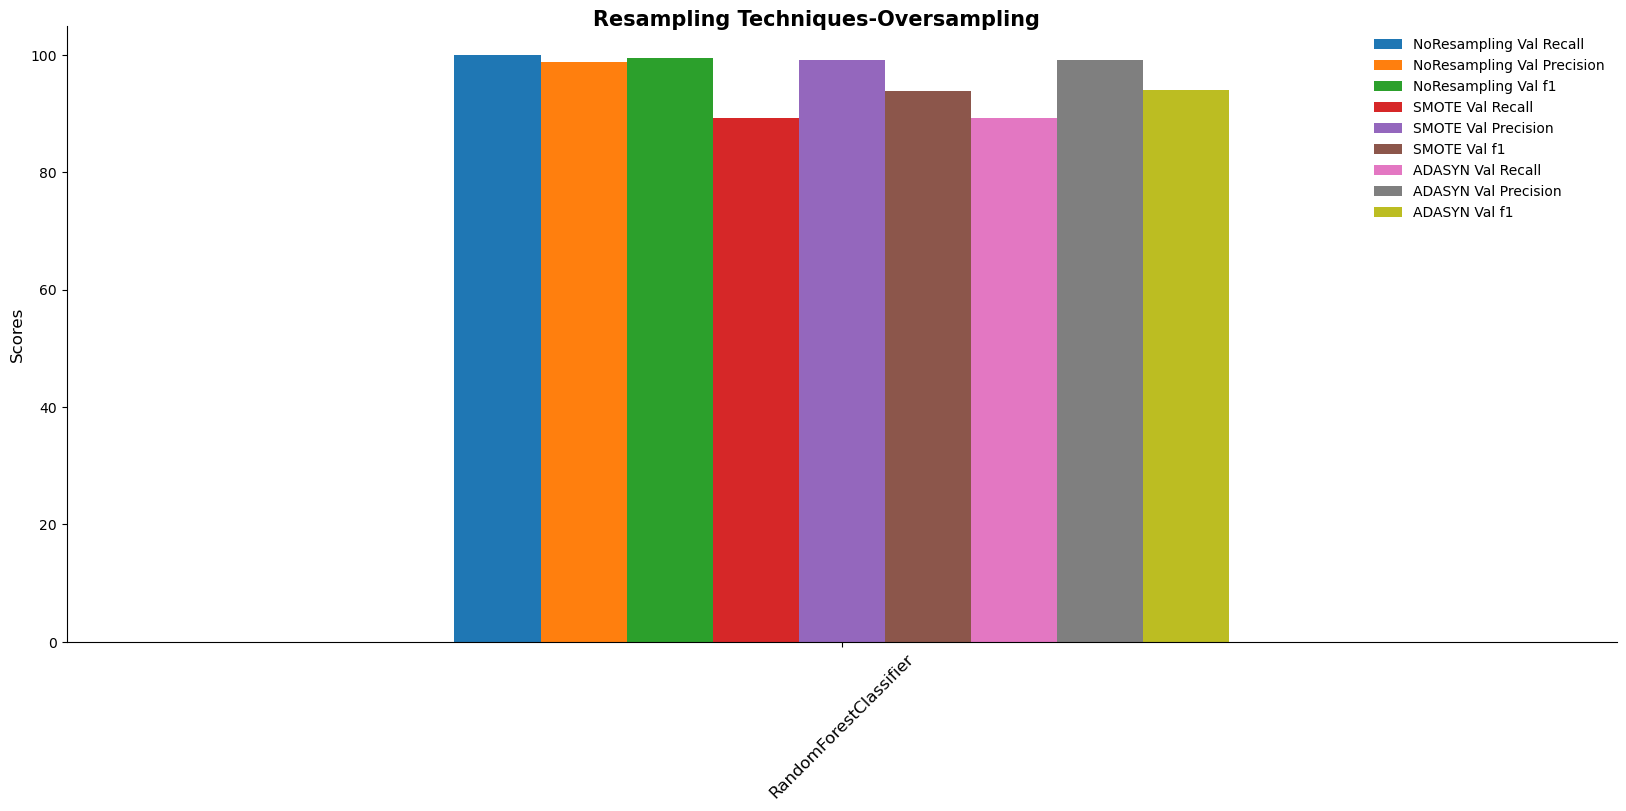

In [17]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_over.plot.bar(ax=ax)
ax.set_ylabel('Scores', fontsize=12)
for spine in ['right', 'top']:
        ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Oversampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [18]:
res_list = [('TomekLinks', TomekLinks()),
            ('NearMiss', NearMiss())]

outputs_u = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=StandardScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_u.append(var[0])
    display(var[1])

------------------------------------------------TomekLinks-------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 5.905073881149292
Resampling done in 4.11696720123291
Resampling done in 4.201613426208496
Resampling done in 4.312490940093994
Resampling done in 5.786028146743774


,Run Time,Train Accuracy,Train Precision,Train Recall,Train f1,Val Accuracy,Val Precision,Val Recall,Val f1
RandomForestClassifier,10.328305,98.89%,98.89%,100.00%,99.44%,98.80%,98.81%,99.99%,99.40%


-------------------------------------------------NearMiss--------------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.2030959129333496
Resampling done in 0.20429778099060059
Resampling done in 0.2127995491027832
Resampling done in 0.21378421783447266
Resampling done in 0.20236706733703613


,Run Time,Train Accuracy,Train Precision,Train Recall,Train f1,Val Accuracy,Val Precision,Val Recall,Val f1
RandomForestClassifier,1.979264,91.11%,85.06%,99.81%,91.84%,33.56%,99.02%,33.11%,49.21%


In [19]:
ps_under = pd.DataFrame(index=models_dict.keys())
ps_under['NoResampling Val Recall'] = auto_run[0]['Val Recall']
ps_under['NoResampling Val Precision'] = auto_run[0]['Val Precision']
ps_under['NoResampling Val f1'] = auto_run[0]['Val f1']
ps_under['TomekLinks Val Recall'] = outputs_u[0]['Val Recall']
ps_under['TomekLinks Val Precision'] = outputs_u[0]['Val Precision']
ps_under['TomekLinks Val f1'] = outputs_u[0]['Val f1']
ps_under['NearMiss Val Recall'] = outputs_u[1]['Val Recall']
ps_under['NearMiss Val Precision'] = outputs_u[1]['Val Precision']
ps_under['NearMiss Val f1'] = outputs_u[1]['Val f1']
ps_under

,NoResampling Val Recall,NoResampling Val Precision,NoResampling Val f1,TomekLinks Val Recall,TomekLinks Val Precision,TomekLinks Val f1,NearMiss Val Recall,NearMiss Val Precision,NearMiss Val f1
RandomForestClassifier,99.99,98.82,99.4,99.99,98.81,99.4,33.11,99.02,49.21


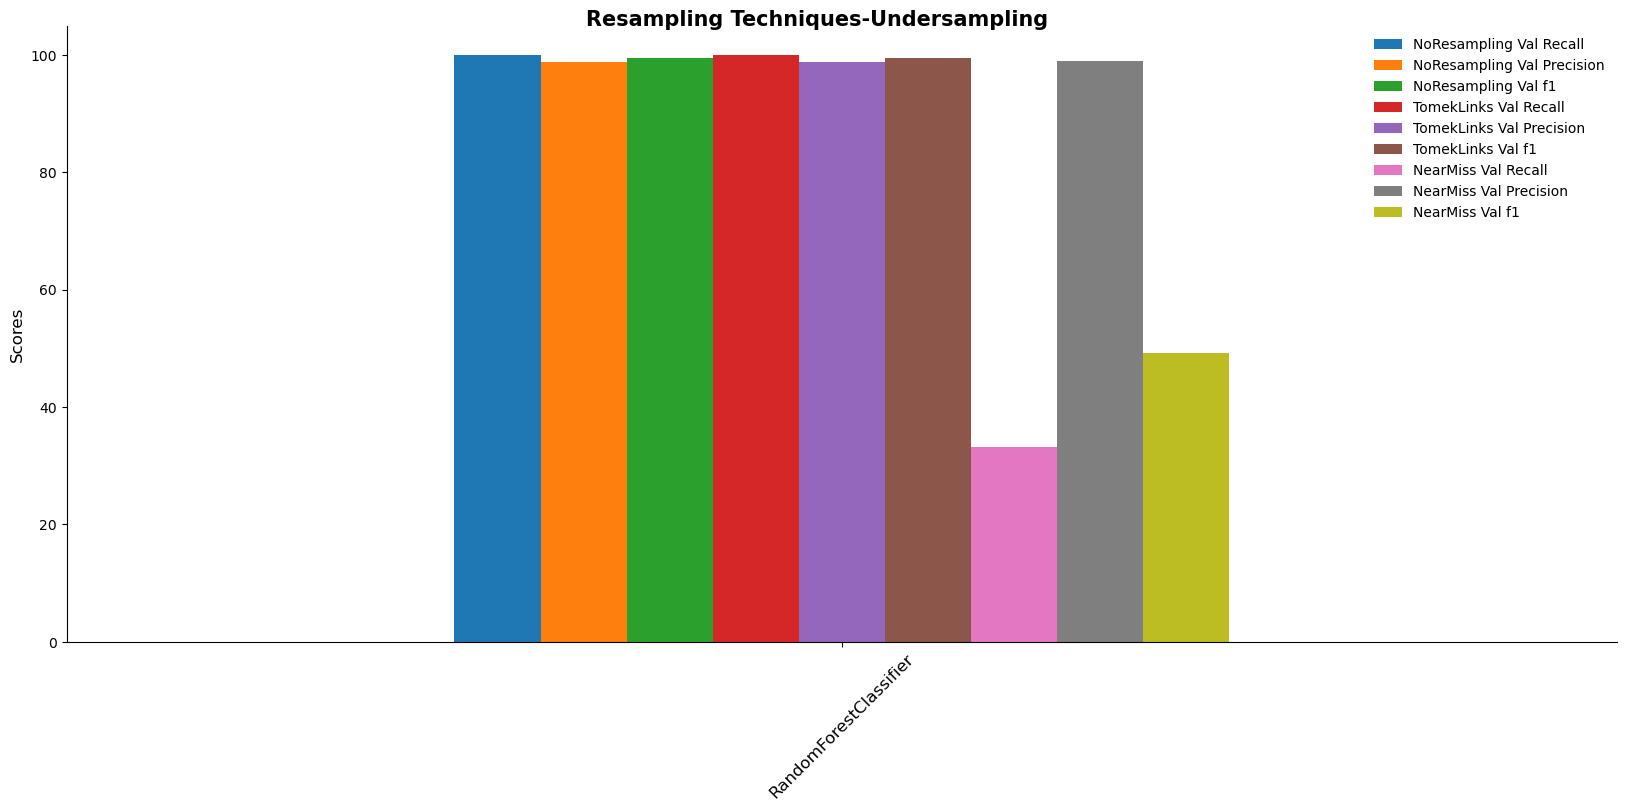

In [20]:
fig, ax = plt.subplots(figsize=(20, 8))
ps_under.plot.bar(ax=ax)
ax.set_ylabel('Scores', fontsize=12)
for spine in ['right', 'top']:
    ax.spines[spine].set_visible(False)
ax.legend(edgecolor='white')
fig.suptitle("Resampling Techniques-Undersampling", size=15, y=0.9, weight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.show()

In [21]:
res_list = [('RandomUnderSampler', RandomUnderSampler(sampling_strategy="majority")),
            ('RandomOverSampler', RandomOverSampler(sampling_strategy="minority"))]

outputs_x = []
for title, res in res_list:
    print(colored(title, 'red', attrs=['bold']).center(120, "-"))
    var = auto_ml(X_trainval, y_trainval, models_dict, scaler=StandardScaler(),
                  cv=StratifiedKFold(n_splits=5), res_t=res)
    outputs_x.append(var[0])
    display(var[1])

--------------------------------------------RandomUnderSampler---------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.08954930305480957
Resampling done in 0.07366776466369629
Resampling done in 0.08188271522521973
Resampling done in 0.10829424858093262
Resampling done in 0.08140110969543457


,Run Time,Train Accuracy,Train Precision,Train Recall,Train f1,Val Accuracy,Val Precision,Val Recall,Val f1
RandomForestClassifier,2.008877,95.28%,94.97%,95.74%,95.32%,74.78%,99.56%,74.81%,85.41%


---------------------------------------------RandomOverSampler---------------------------------------------


  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Resampling done in 0.37163853645324707
Resampling done in 0.3295440673828125
Resampling done in 0.38020896911621094
Resampling done in 0.38939547538757324
Resampling done in 0.3796265125274658


,Run Time,Train Accuracy,Train Precision,Train Recall,Train f1,Val Accuracy,Val Precision,Val Recall,Val f1
RandomForestClassifier,19.838179,92.22%,90.39%,94.67%,92.44%,93.62%,99.17%,94.33%,96.68%


In [22]:
def train_rf(X, y, metric, res_t=None, hypertune=False, resample=False):
    params = {"n_estimators": [100, 200, 300],
              "max_depth": [5, 10, 15, 20]
             } # specify parameters
    new_params = {'randomforestclassifier__' +
                  key: params[key] for key in params}

    skf = StratifiedKFold(n_splits=5)
    if resample is True:
        imba_pipeline = make_pipeline(StandardScaler(),
                                      res_t,
                                      RandomForestClassifier(random_state=143))
    else:
        imba_pipeline = make_pipeline(StandardScaler(),
                                      RandomForestClassifier(random_state=143))

    if hypertune is True:
        clf = GridSearchCV(imba_pipeline, param_grid=new_params,
                           cv=skf, scoring=metric, return_train_score=True,
                          verbose=10)
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        model = clf.best_estimator_.fit(X, y)
        return ['Random Forest Classifier', np.mean(clf.cv_results_['mean_train_score']),
                clf.best_score_, 'Best parameters = {0}'.format(
                    clf.best_params_),
                run_time, model]
    else:
        clf = imba_pipeline
        start_time = time.time()
        clf.fit(X, y)
        run_time = (time.time() - start_time)
        cv_scores = cross_validate(estimator=clf, X=X, y=y,
                                   scoring=metric, cv=skf, n_jobs=-1,
                                   return_train_score=True)

        return ['Random Forest Classifier', np.mean(cv_scores['train_score']),
                np.mean(cv_scores['test_score']), run_time, clf]

In [23]:
rf_tk_acc = train_rf(X_trainval, y_trainval, 'accuracy', RandomUnderSampler(sampling_strategy="majority"),
                      hypertune=True, resample=True)
rf_tk_rec = train_rf(X_trainval, y_trainval, 'recall', RandomUnderSampler(sampling_strategy="majority"),
                       hypertune=True, resample=True)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=100
[CV 1/5; 1/12] END randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=100;, score=(train=0.651, test=0.660) total time=   0.4s
[CV 2/5; 1/12] START randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=100
[CV 2/5; 1/12] END randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=100;, score=(train=0.742, test=0.767) total time=   0.4s
[CV 3/5; 1/12] START randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=100
[CV 3/5; 1/12] END randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=100;, score=(train=0.728, test=0.715) total time=   0.3s
[CV 4/5; 1/12] START randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=100
[CV 4/5; 1/12] END randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=

[CV 4/5; 7/12] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=100;, score=(train=0.661, test=0.659) total time=   0.4s
[CV 5/5; 7/12] START randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=100
[CV 5/5; 7/12] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=100;, score=(train=0.701, test=0.686) total time=   0.4s
[CV 1/5; 8/12] START randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=200
[CV 1/5; 8/12] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=200;, score=(train=0.749, test=0.750) total time=   0.7s
[CV 2/5; 8/12] START randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=200
[CV 2/5; 8/12] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=200;, score=(train=0.727, test=0.723) total time=   0.7s
[CV 3/5; 8/12] START randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=

[CV 2/5; 2/12] END randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=200;, score=(train=0.768, test=0.766) total time=   0.6s
[CV 3/5; 2/12] START randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=200
[CV 3/5; 2/12] END randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=200;, score=(train=0.761, test=0.750) total time=   0.6s
[CV 4/5; 2/12] START randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=200
[CV 4/5; 2/12] END randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=200;, score=(train=0.716, test=0.719) total time=   0.6s
[CV 5/5; 2/12] START randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=200
[CV 5/5; 2/12] END randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=200;, score=(train=0.739, test=0.728) total time=   0.6s
[CV 1/5; 3/12] START randomforestclassifier__max_depth=5, randomforestclassifier__n_estimators=300
[CV 

[CV 5/5; 8/12] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=200;, score=(train=0.776, test=0.769) total time=   0.7s
[CV 1/5; 9/12] START randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=300
[CV 1/5; 9/12] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=300;, score=(train=0.746, test=0.745) total time=   1.0s
[CV 2/5; 9/12] START randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=300
[CV 2/5; 9/12] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=300;, score=(train=0.731, test=0.734) total time=   1.0s
[CV 3/5; 9/12] START randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=300
[CV 3/5; 9/12] END randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=300;, score=(train=0.719, test=0.714) total time=   1.1s
[CV 4/5; 9/12] START randomforestclassifier__max_depth=15, randomforestclassifier__n_estimators=

In [24]:
cols = ['', 'Train Accuracy', 'Val Accuracy',
        'Train Recall', 'Val Recall']
hyper = pd.DataFrame(columns=cols)
hyper.loc[0] = [rf_tk_rec[0],
                np.round(rf_tk_acc[1]*100, 6),
                np.round(rf_tk_acc[2]*100, 6),
                np.round(rf_tk_rec[1]*100, 6),
                np.round(rf_tk_rec[2]*100, 6)]
hyper2 = pd.DataFrame(columns=cols)
hyper2.loc[0] = [rf_tk_rec[0],
                 '{:.2f}%'.format(np.round(rf_tk_acc[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tk_acc[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tk_rec[2]*100, 2))]
hyper2.style.hide_index()

,Train Accuracy,Val Accuracy,Train Recall,Val Recall
Random Forest Classifier,73.76%,76.84%,73.28%,75.82%


In [25]:
# re-fitting for the holdout
rf_rec = rf_tk_rec[-1]
# RUS = RandomUnderSampler()
# X_trainval, y_trainval = RUS.fit_resample(X_trainval, y_trainval)
rf_rec.fit(X_trainval, y_trainval)
rf_rec_y_preds = rf_rec.predict(X_holdout)
rf_rec_holdout_score = precision_score(y_holdout, rf_rec_y_preds)

In [26]:
# cross-validation
base_var = train_rf(X_trainval, y_trainval, 'recall', hypertune=False, resample=False)

# re-fitting for the holdout
base_model = base_var[-1]
base_model.fit(X_trainval, y_trainval)
y_preds = base_model.predict(X_holdout)
holdout_score = precision_score(y_holdout, y_preds)

In [27]:
cols = ['Method', 'Train Recall', 'Val Recall', 'Holdout Recall']
summary = pd.DataFrame(columns=cols)
summary.loc[0] = ['No Resampling',
                 '{:.2f}%'.format(np.round(base_var[1]*100, 2)),
                 '{:.2f}%'.format(np.round(base_var[2]*100, 2)),
                 '{:.2f}%'.format(np.round(holdout_score*100, 2))]
summary.loc[3] = ['Resampling x Hypertune',
                 '{:.2f}%'.format(np.round(rf_tk_rec[1]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_tk_rec[2]*100, 2)),
                 '{:.2f}%'.format(np.round(rf_rec_holdout_score*100, 2))]
summary.style.hide_index()

Method,Train Recall,Val Recall,Holdout Recall
No Resampling,99.98%,99.69%,98.91%
Resampling x Hypertune,73.28%,75.82%,99.34%


In [28]:
rf_tk_acc

['Random Forest Classifier',
 0.7376015487086534,
 0.7683785048198645,
 "Best parameters = {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 300}",
 77.08726644515991,
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomundersampler',
                  RandomUnderSampler(sampling_strategy='majority')),
                 ('randomforestclassifier',
                  RandomForestClassifier(max_depth=5, n_estimators=300,
                                         random_state=143))])]

In [29]:
rf_tk_rec

['Random Forest Classifier',
 0.7328032025029124,
 0.7582149936410285,
 "Best parameters = {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__n_estimators': 100}",
 75.8048484325409,
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomundersampler',
                  RandomUnderSampler(sampling_strategy='majority')),
                 ('randomforestclassifier',
                  RandomForestClassifier(max_depth=5, random_state=143))])]

# Model Explainability

In [30]:
model = rf_rec['randomforestclassifier']

In [31]:
# save as pickle file
pickle.dump(model, open(r'C:\Users\Jamie\esk\esk_sprint2\project_sprint2\data_exploration\rf_school_type_final.pkl', 'wb'))

In [32]:
import joblib
from joblib import dump, load

In [33]:
model = joblib.load(r'C:\Users\Jamie\esk\esk_sprint2\project_sprint2\data_exploration\rf_school_type_final.pkl')

**------------------------------------------------------------------------------------------- X_holdout Issue -------------------------------------------------------------------------------------------**

### Output Transformed X_holdout

In [34]:
from sklearn.preprocessing import StandardScaler

**1) Standard Scale X_trainval first:**

In [35]:
scaler = StandardScaler()

In [36]:
pop_df = X_trainval['population_as_of_may_2020']
pop_df.head(n=3)

14767    2310134
5400      669840
7801      250985
Name: population_as_of_may_2020, dtype: int64

In [37]:
scaler.fit(pop_df.to_numpy().reshape(-1,1))

StandardScaler()

In [38]:
scaler.mean_

array([1676203.38840117])

**2) Apply scaling to X_holdout data set:**

In [39]:
X_holdout_pop = X_holdout['population_as_of_may_2020']
X_holdout_pop.head(n=3)

13194    4344829
6092      739367
1056      827041
Name: population_as_of_may_2020, dtype: int64

In [40]:
X_holdout_pop_scaled = scaler.transform(X_holdout_pop.to_numpy().reshape(-1, 1))
X_holdout_pop_scaled

array([[ 2.21452066],
       [-0.77742023],
       [-0.70466522],
       ...,
       [-0.85800723],
       [ 2.21452066],
       [-0.45736092]])

In [41]:
# Convert array to df
X_holdout_pop_scaled_df = pd.DataFrame(X_holdout_pop_scaled, columns=['population_as_of_may_2020'])
X_holdout_pop_scaled_df.head(n=3)

,population_as_of_may_2020
0,2.214521
1,-0.777420
2,-0.704665


**3) Combine with orig X_holdout data set:**

In [42]:
X_holdout_new = X_holdout.drop(labels=['population_as_of_may_2020'], axis=1)
X_holdout_new = pd.concat([X_holdout_new.reset_index(), X_holdout_pop_scaled_df], axis=1)
X_holdout_new.drop(labels=['index'], axis=1, inplace=True)
X_holdout_new.head(n=3)

,total_enrollees,total_instructors,poverty_incidence_among_families,unemployment_rate_per_region,region_ARMM,region_CAR,region_CARAGA,region_NCR,region_REGION I,region_REGION II,region_REGION III,region_REGION IVA,region_REGION IVB,region_REGION IX,region_REGION V,region_REGION VI,region_REGION VII,region_REGION VIII,region_REGION X,region_REGION XI,region_REGION XII,province_ABRA,province_AGUSAN DEL NORTE,province_AGUSAN DEL SUR,province_AKLAN,province_ALBAY,province_ANTIQUE,province_APAYAO,province_AURORA,province_BASILAN,province_BATAAN,province_BATANES,province_BATANGAS,province_BENGUET,province_BILIRAN,province_BOHOL,province_BUKIDNON,province_BULACAN,province_CAGAYAN,province_CAMARINES NORTE,province_CAMARINES SUR,province_CAMIGUIN,province_CAPIZ,province_CATANDUANES,province_CAVITE,province_CEBU,province_CITY OF COTABATO,province_COMPOSTELA VALLEY,province_DAVAO DEL NORTE,province_DAVAO DEL SUR,province_DAVAO ORIENTAL,province_DINAGAT ISLANDS,province_EASTERN SAMAR,province_GUIMARAS,province_IFUGAO,province_ILOCOS NORTE,province_ILOCOS SUR,province_ILOILO,province_ISABELA,province_KALINGA,province_LA UNION,province_LAGUNA,province_LANAO DEL NORTE,province_LANAO DEL SUR,province_LEYTE,province_MAGUINDANAO,"province_MANILA, NCR, FIRST DISTRICT",province_MARINDUQUE,province_MASBATE,province_MISAMIS OCCIDENTAL,province_MISAMIS ORIENTAL,province_MOUNTAIN PROVINCE,province_NCR FOURTH DISTRICT,province_NCR SECOND DISTRICT,province_NCR THIRD DISTRICT,province_NEGROS OCCIDENTAL,province_NEGROS ORIENTAL,province_NORTH COTABATO,province_NORTHERN SAMAR,province_NUEVA ECIJA,province_OCCIDENTAL MINDORO,province_ORIENTAL MINDORO,province_PALAWAN,province_PAMPANGA,province_PANGASINAN,province_QUEZON,province_QUIRINO,province_RIZAL,province_ROMBLON,province_SARANGANI,province_SIQUIJOR,province_SORSOGON,province_SOUTH COTABATO,province_SOUTHERN LEYTE,province_SULTAN KUDARAT,province_SULU,province_SURIGAO DEL NORTE,province_SURIGAO DEL SUR,province_TARLAC,province_TAWI-TAWI,province_WESTERN SAMAR,province_ZAMBALES,province_ZAMBOANGA DEL NORTE,province_ZAMBOANGA DEL SUR,province_ZAMBOANGA SIBUGAY,legislative_1ST,legislative_2ND,legislative_3RD,legislative_4TH,legislative_5TH,legislative_6TH,legislative_7TH,legislative_LONE,division_ABRA,division_AGUSAN DEL NORTE,division_AGUSAN DEL SUR,division_AKLAN,division_ALAMINOS CITY,division_ALBAY,division_ANGELES CITY,division_ANTIPOLO CITY,division_ANTIQUE,division_APAYAO,division_AURORA,division_BACOLOD CITY,division_BAGO CITY,division_BAGUIO CITY,division_BAIS CITY,division_BALANGA CITY,division_BASILAN,division_BATAAN,division_BATANES,division_BATANGAS,division_BATANGAS CITY,division_BAYAWAN CITY,division_BENGUET,division_BILIRAN,division_BISLIG CITY,division_BOGO CITY,division_BOHOL,division_BUKIDNON,division_BULACAN,division_BUTUAN CITY,division_CABANATUAN CITY,division_CADIZ CITY,division_CAGAYAN,division_CAGAYAN DE ORO CITY,division_CALAMBA CITY,division_CALAPAN CITY,division_CALBAYOG CITY,division_CALOOCAN CITY,division_CAMARINES NORTE,division_CAMARINES SUR,division_CAMIGUIN,division_CANDON CITY,division_CAPIZ,division_CARCAR CITY,division_CATANDUANES,division_CAUAYAN CITY,division_CAVITE,division_CAVITE CITY,division_CEBU,division_CEBU CITY,division_CITY OF NAGA CEBU,division_CITY OF SAN JUAN,division_COMPOSTELA VALLEY,division_COTABATO CITY,division_DAGUPAN CITY,division_DANAO CITY,division_DASMARINAS CITY,division_DAVAO CITY,division_DAVAO DEL NORTE,division_DAVAO DEL SUR,division_DAVAO ORIENTAL,division_DIGOS CITY,division_DINAGAT ISLAND,division_DIPOLOG CITY,division_DUMAGUETE CITY,division_EASTERN SAMAR,division_ESCALANTE CITY,division_GAPAN CITY,division_GENERAL SANTOS CITY,division_GINGOOG CITY,division_GUIHULNGAN CITY,division_GUIMARAS,division_IFUGAO,division_ILIGAN CITY,division_ILOCOS NORTE,division_ILOCOS SUR,division_ILOILO,division_ILOILO CITY,division_IRIGA CITY,division_ISABELA,division_ISLAND GARDEN CITY OF SAMAL,division_KABANKALAN CITY,division_KALINGA,division_KIDAPAW

**--------------------------------------------------------------------------------------- END X_holdout Issue ---------------------------------------------------------------------------------------**

## Confusion Matrix

In [43]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [44]:
model

RandomForestClassifier(max_depth=5, random_state=143)

In [45]:
proba = model.predict_proba(X_holdout_new)
proba

array([[0.41618609, 0.58381391],
       [0.41618609, 0.58381391],
       [0.4338784 , 0.5661216 ],
       ...,
       [0.43938976, 0.56061024],
       [0.41618609, 0.58381391],
       [0.41618609, 0.58381391]])

In [46]:
print("Min & Max probability values")
df_proba = pd.DataFrame(proba)
df_proba.rename(columns = {0 : 'probability'}, inplace = True)
print(df_proba.min(),df_proba.max())

Min & Max probability values
probability    0.393656
1              0.502036
dtype: float64 probability    0.497964
1              0.606344
dtype: float64


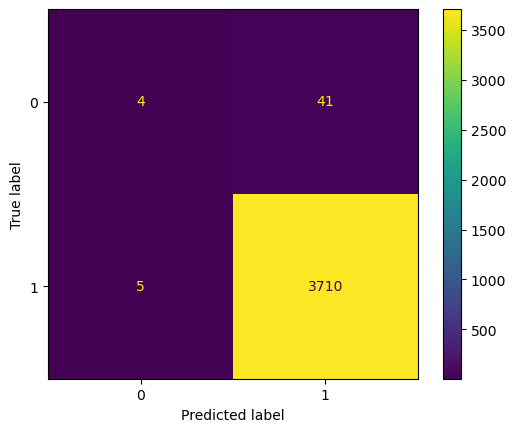

In [47]:
cm = confusion_matrix(y_holdout, y_preds, labels = model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = model.classes_)

disp.plot()
plt.show()

In [48]:
y_holdout.head()

13194    1
6092     1
1056     1
1517     1
4514     1
Name: school_type, dtype: int64

In [49]:
proba

array([[0.41618609, 0.58381391],
       [0.41618609, 0.58381391],
       [0.4338784 , 0.5661216 ],
       ...,
       [0.43938976, 0.56061024],
       [0.41618609, 0.58381391],
       [0.41618609, 0.58381391]])

In [50]:
# Confusion Matrix and Model Performance
cm

tn, fp, fn, tp = confusion_matrix(np.ravel(y_holdout), y_preds).ravel()


# Compute for auc roc score
# auc = roc_auc_score(y_holdout, proba)
auc = roc_auc_score(y_holdout, proba[:,1])

# Compute for the accuracy
accuracy = accuracy_score(y_holdout, y_preds)

print("Confusion Matrix: ")
print(cm)

print("Classification Report")
print(classification_report(y_holdout, y_preds))

print('Accuracy is: %4.4f'%(accuracy * 100), "%")
print('True Positive Rate: %4.4f'%((tp/(tp+fn)*100)), "%")
print('True Negative Rate: %4.4f'%((tn/(tn+fp)*100)), "%")
print('AUC ROC Score: %4.4f'%(auc * 100), "%")

Confusion Matrix: 
[[   4   41]
 [   5 3710]]
Classification Report
              precision    recall  f1-score   support

           0       0.44      0.09      0.15        45
           1       0.99      1.00      0.99      3715

    accuracy                           0.99      3760
   macro avg       0.72      0.54      0.57      3760
weighted avg       0.98      0.99      0.98      3760

Accuracy is: 98.7766 %
True Positive Rate: 99.8654 %
True Negative Rate: 8.8889 %
AUC ROC Score: 50.9119 %


In [51]:
# Output all Model Metrics
cm_v2 = ConfusionMatrix(np.ravel(y_holdout).astype('int64'), y_preds.astype('int64'))
over_stat = cm_v2.overall_stat
print(cm_v2)

# cm_fin_v2 = ConfusionMatrix(np.ravel(te_y_fin).astype('int64'), predicted_fin.astype('int64'))
# over_stat = cm_fin_v2.overall_stat
# print(cm_fin_v2)

Predict    0          1          
Actual
0          4          41         

1          5          3710       





Overall Statistics : 

95% CI                                                            (0.98425,0.99128)
ACC Macro                                                         0.98777
ARI                                                               0.14294
AUNP                                                              0.54377
AUNU                                                              0.54377
Bangdiwala B                                                      0.98771
Bennett S                                                         0.97553
CBA                                                               0.53898
CSI                                                               0.26053
Chi-Squared                                                       142.6962
Chi-Squared DF                                                    1
Conditional Entropy                        

## ROC
X, y = load_wine(return_X_y=True)<br>
y = y == 2<br>
<br>
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)<br>
svc = SVC(random_state=42)<br>
svc.fit(X_train, y_train)

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

In [53]:
r_proba  = [0 for _ in range(len(y_holdout))]

# Random Prediction: 50% probability
r_auc             = roc_auc_score(y_holdout, r_proba)
r_fpr,  r_tpr,  _ = roc_curve(y_holdout, r_proba)

# Calculate ROC curve
r_fpr, r_tpr, _  = roc_curve(y_holdout, r_proba)
fpr,   tpr,   _  = roc_curve(y_holdout, proba[:,1])

Random Prediction: AUROC is 50.00 %
Random Forest: AUROC is 50.91 %


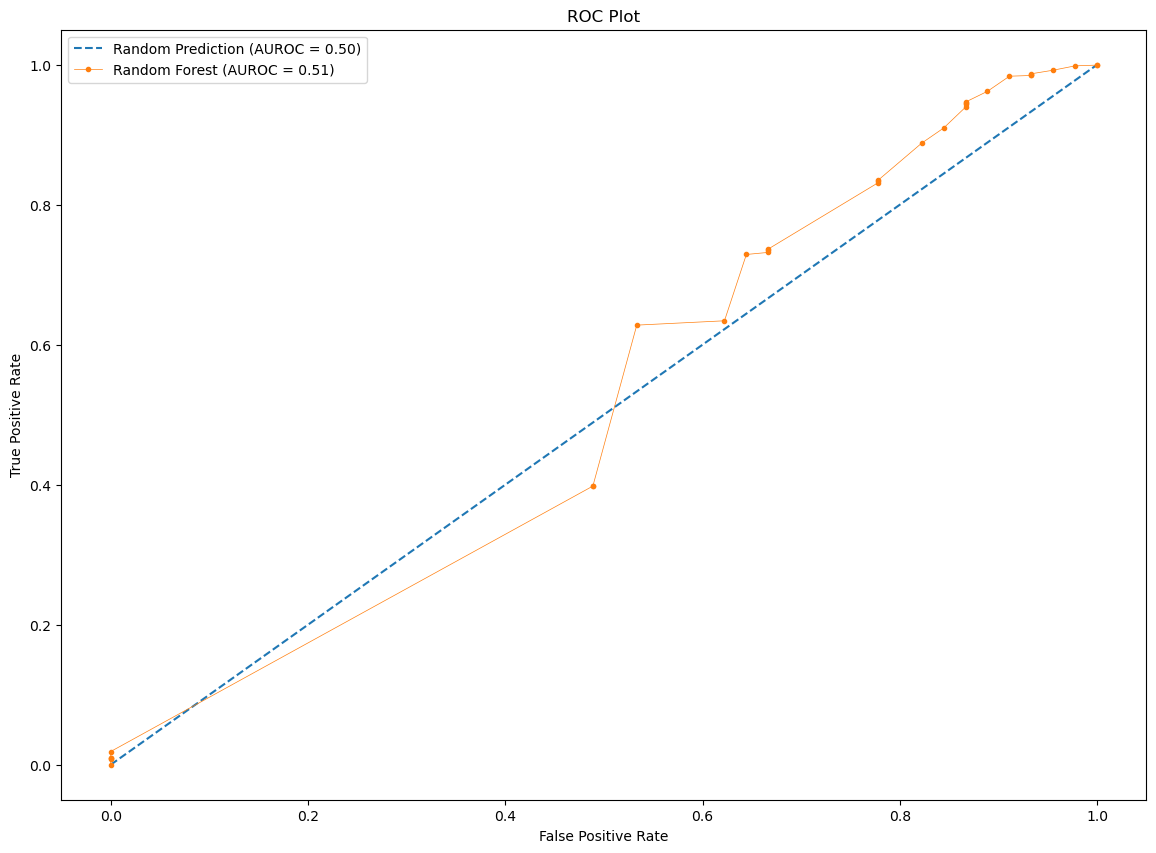

In [54]:
# Print AUROC scores over the graph
print('Random Prediction: AUROC is %.2f' % (r_auc*100),"%")
print('Random Forest: AUROC is %.2f' % (auc*100),"%")


# Plot the ROC curve
plt.rcParams["figure.figsize"] = (14,10)

plt.plot(r_fpr,  r_tpr, linestyle='--', label='Random Prediction (AUROC = %0.2f)' % r_auc)
plt.plot(fpr,    tpr,   marker='.', label='Random Forest (AUROC = %0.2f)' % auc, linewidth=0.5)

plt.legend()
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

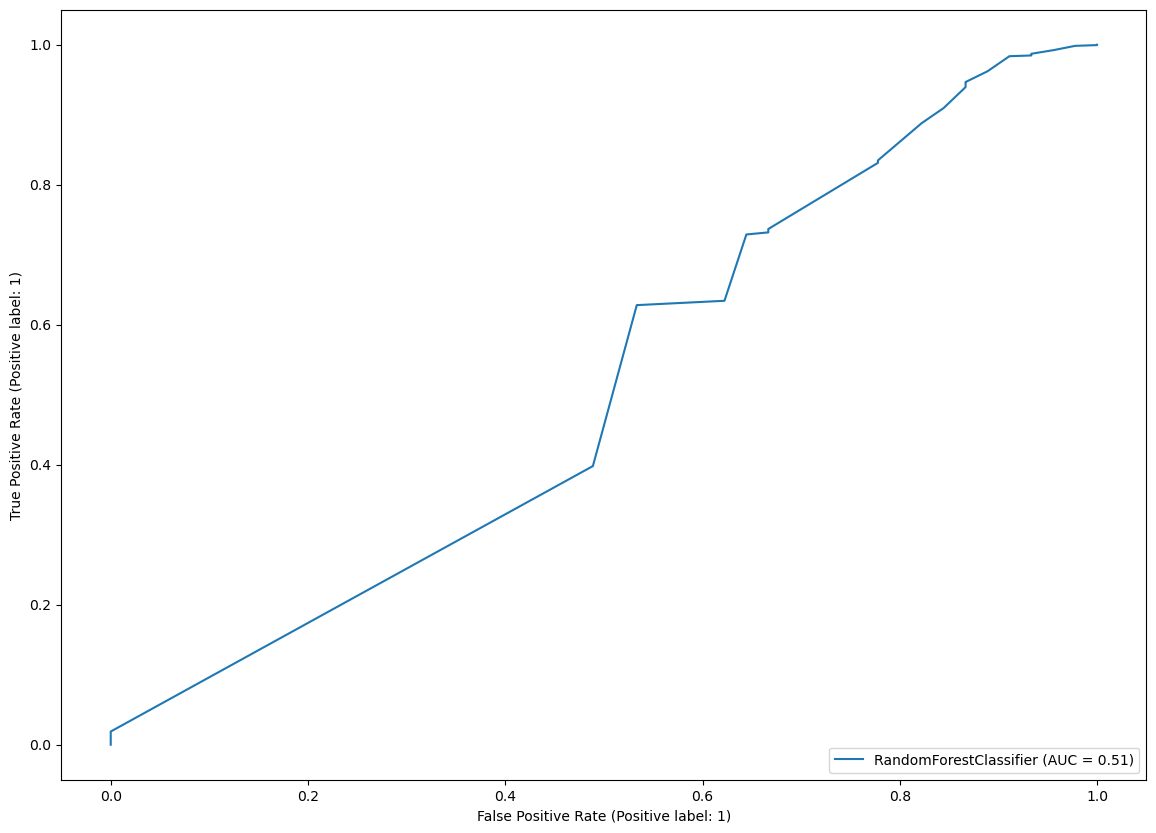

In [55]:
rf_disp = RocCurveDisplay.from_estimator(model, X_holdout_new, y_holdout)
plt.show()

## SHAP

school_type: 0 = Extension School, 1 = Lone School

In [56]:
# Initialize the explainer
explainer   = shap.TreeExplainer(model, feature_names=X_holdout_new.columns)

In [57]:
# Compute the SHAP values
shap_values = explainer.shap_values(X_holdout_new, check_additivity=False)

school_type: 0 = Extension School, 1 = Lone School

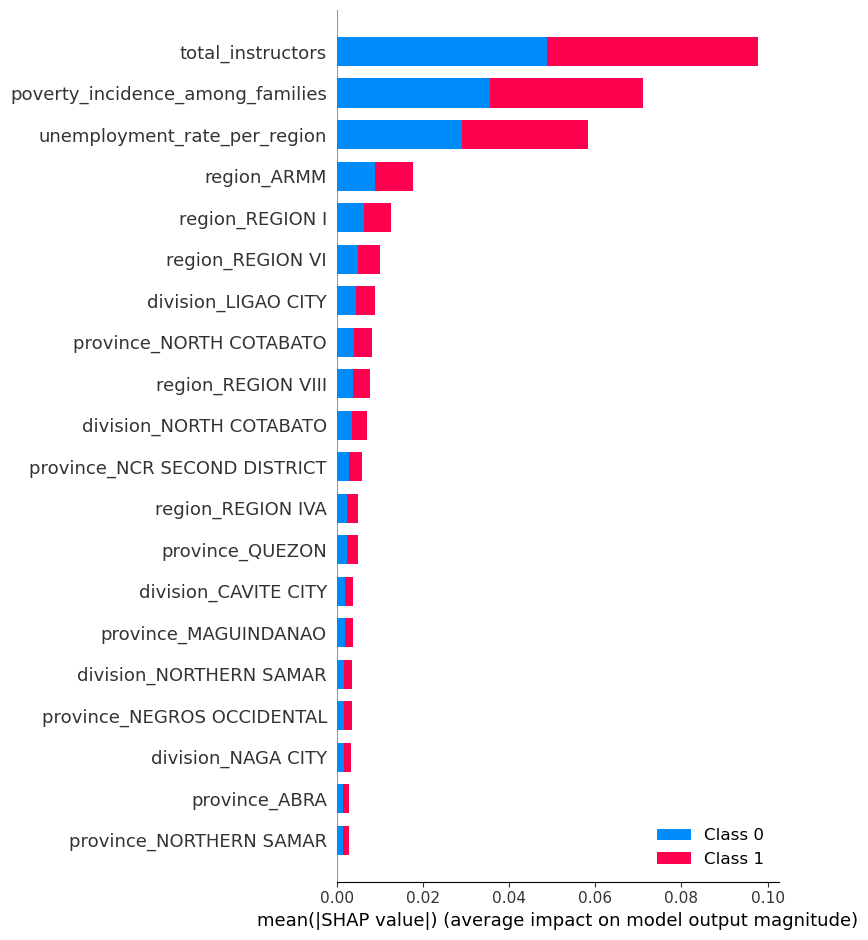

In [58]:
# Feature Importance
shap.summary_plot(shap_values, X_holdout_new.columns, plot_type='bar')

school_type: 0 = Extension School, 1 = Lone School

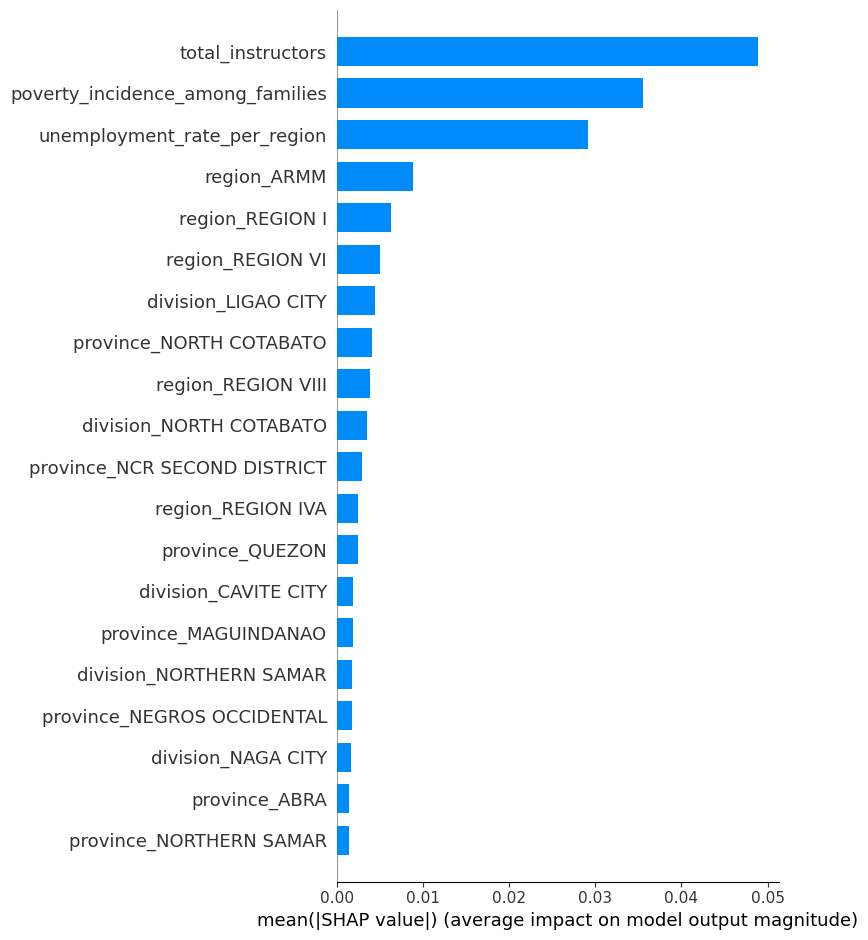

In [70]:
# Feature Importance
# Class 0 (Extension School) is indexed at 0
shap.summary_plot(shap_values[0], X_holdout_new.columns, plot_type='bar')

school_type: 0 = Extension School, 1 = Lone School

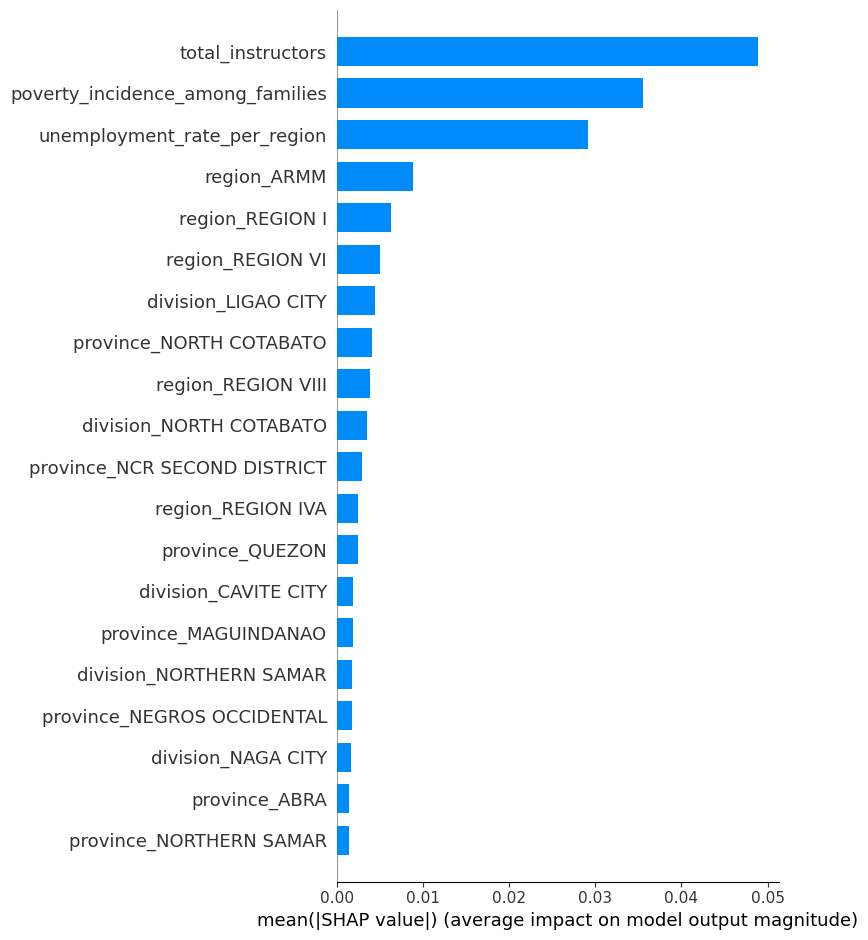

In [60]:
# Feature Importance
# Class 1 (Lone School) is indexed at 1
shap.summary_plot(shap_values[1], X_school_type: 0 = Extension School, 1 = Lone Schoolholdout_new.columns, plot_type='bar')

school_type: 0 = Extension School, 1 = Lone School

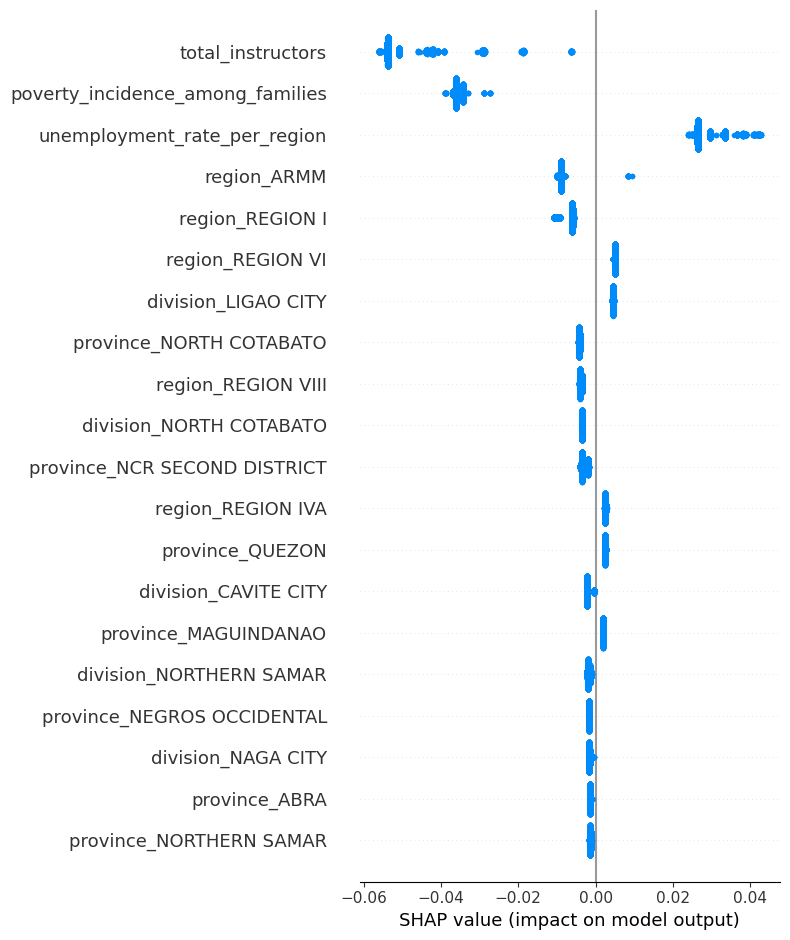

In [61]:
# Class 0 (Extension Schools) is indexed at 0
shap.summary_plot(shap_values = shap_values[0], 
                  features    = X_holdout_new.columns,
                  plot_type   = 'dot'
                  )

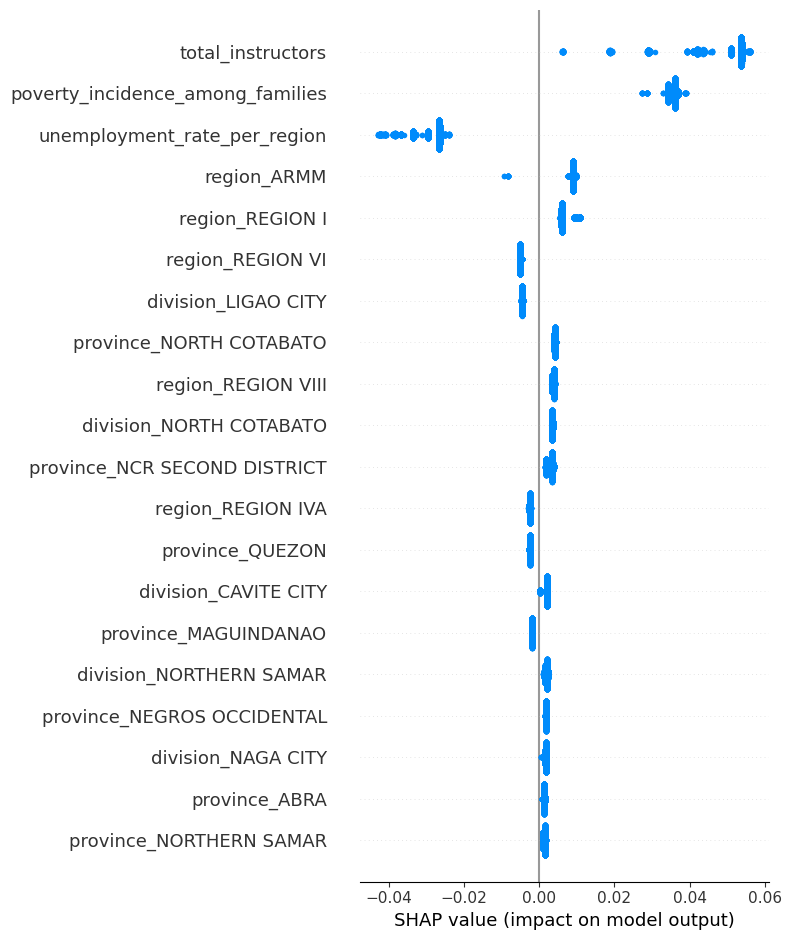

In [62]:
# Class 1 (Lone Schools) is indexed at 1
shap.summary_plot(shap_values = shap_values[1], 
                  features    = X_holdout_new.columns,
                  plot_type   = 'dot'
                  )

## Force Plots

In [63]:
y_df = pd.DataFrame(y_preds, columns=['predicted'])
y_df = pd.concat([y_holdout.reset_index(), y_df], axis=1)
y_df.drop(labels=['index'], axis=1, inplace=True)
y_df.head()

,school_type,predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1


### <u> Example for y_predicted and y_actual is 1 (Lone School) </u>

In [64]:
y_df.loc[(y_df['school_type'] == 1) & (y_df['predicted'] == 1)]

,school_type,predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,1
8,1,1
9,1,1


In [65]:
chosen_instance_1 = X_holdout_new.loc[[343]]
chosen_instance_1

,total_enrollees,total_instructors,poverty_incidence_among_families,unemployment_rate_per_region,region_ARMM,region_CAR,region_CARAGA,region_NCR,region_REGION I,region_REGION II,region_REGION III,region_REGION IVA,region_REGION IVB,region_REGION IX,region_REGION V,region_REGION VI,region_REGION VII,region_REGION VIII,region_REGION X,region_REGION XI,region_REGION XII,province_ABRA,province_AGUSAN DEL NORTE,province_AGUSAN DEL SUR,province_AKLAN,province_ALBAY,province_ANTIQUE,province_APAYAO,province_AURORA,province_BASILAN,province_BATAAN,province_BATANES,province_BATANGAS,province_BENGUET,province_BILIRAN,province_BOHOL,province_BUKIDNON,province_BULACAN,province_CAGAYAN,province_CAMARINES NORTE,province_CAMARINES SUR,province_CAMIGUIN,province_CAPIZ,province_CATANDUANES,province_CAVITE,province_CEBU,province_CITY OF COTABATO,province_COMPOSTELA VALLEY,province_DAVAO DEL NORTE,province_DAVAO DEL SUR,province_DAVAO ORIENTAL,province_DINAGAT ISLANDS,province_EASTERN SAMAR,province_GUIMARAS,province_IFUGAO,province_ILOCOS NORTE,province_ILOCOS SUR,province_ILOILO,province_ISABELA,province_KALINGA,province_LA UNION,province_LAGUNA,province_LANAO DEL NORTE,province_LANAO DEL SUR,province_LEYTE,province_MAGUINDANAO,"province_MANILA, NCR, FIRST DISTRICT",province_MARINDUQUE,province_MASBATE,province_MISAMIS OCCIDENTAL,province_MISAMIS ORIENTAL,province_MOUNTAIN PROVINCE,province_NCR FOURTH DISTRICT,province_NCR SECOND DISTRICT,province_NCR THIRD DISTRICT,province_NEGROS OCCIDENTAL,province_NEGROS ORIENTAL,province_NORTH COTABATO,province_NORTHERN SAMAR,province_NUEVA ECIJA,province_OCCIDENTAL MINDORO,province_ORIENTAL MINDORO,province_PALAWAN,province_PAMPANGA,province_PANGASINAN,province_QUEZON,province_QUIRINO,province_RIZAL,province_ROMBLON,province_SARANGANI,province_SIQUIJOR,province_SORSOGON,province_SOUTH COTABATO,province_SOUTHERN LEYTE,province_SULTAN KUDARAT,province_SULU,province_SURIGAO DEL NORTE,province_SURIGAO DEL SUR,province_TARLAC,province_TAWI-TAWI,province_WESTERN SAMAR,province_ZAMBALES,province_ZAMBOANGA DEL NORTE,province_ZAMBOANGA DEL SUR,province_ZAMBOANGA SIBUGAY,legislative_1ST,legislative_2ND,legislative_3RD,legislative_4TH,legislative_5TH,legislative_6TH,legislative_7TH,legislative_LONE,division_ABRA,division_AGUSAN DEL NORTE,division_AGUSAN DEL SUR,division_AKLAN,division_ALAMINOS CITY,division_ALBAY,division_ANGELES CITY,division_ANTIPOLO CITY,division_ANTIQUE,division_APAYAO,division_AURORA,division_BACOLOD CITY,division_BAGO CITY,division_BAGUIO CITY,division_BAIS CITY,division_BALANGA CITY,division_BASILAN,division_BATAAN,division_BATANES,division_BATANGAS,division_BATANGAS CITY,division_BAYAWAN CITY,division_BENGUET,division_BILIRAN,division_BISLIG CITY,division_BOGO CITY,division_BOHOL,division_BUKIDNON,division_BULACAN,division_BUTUAN CITY,division_CABANATUAN CITY,division_CADIZ CITY,division_CAGAYAN,division_CAGAYAN DE ORO CITY,division_CALAMBA CITY,division_CALAPAN CITY,division_CALBAYOG CITY,division_CALOOCAN CITY,division_CAMARINES NORTE,division_CAMARINES SUR,division_CAMIGUIN,division_CANDON CITY,division_CAPIZ,division_CARCAR CITY,division_CATANDUANES,division_CAUAYAN CITY,division_CAVITE,division_CAVITE CITY,division_CEBU,division_CEBU CITY,division_CITY OF NAGA CEBU,division_CITY OF SAN JUAN,division_COMPOSTELA VALLEY,division_COTABATO CITY,division_DAGUPAN CITY,division_DANAO CITY,division_DASMARINAS CITY,division_DAVAO CITY,division_DAVAO DEL NORTE,division_DAVAO DEL SUR,division_DAVAO ORIENTAL,division_DIGOS CITY,division_DINAGAT ISLAND,division_DIPOLOG CITY,division_DUMAGUETE CITY,division_EASTERN SAMAR,division_ESCALANTE CITY,division_GAPAN CITY,division_GENERAL SANTOS CITY,division_GINGOOG CITY,division_GUIHULNGAN CITY,division_GUIMARAS,division_IFUGAO,division_ILIGAN CITY,division_ILOCOS NORTE,division_ILOCOS SUR,division_ILOILO,division_ILOILO CITY,division_IRIGA CITY,division_ISABELA,division_ISLAND GARDEN CITY OF SAMAL,division_KABANKALAN CITY,division_KALINGA,division_KIDAPAW

In [66]:
sv_1 = explainer.shap_values(chosen_instance_1)
shap.force_plot(explainer.expected_value[0], sv_1[0], chosen_instance_1)

### <u> Example for y_predicted and y_actual is 0 (Extension School) </u>

In [67]:
y_df.loc[(y_df['school_type'] == 0) & (y_df['predicted'] == 0)]

,school_type,predicted
2108,0,0
2661,0,0
2690,0,0
2796,0,0


In [68]:
chosen_instance_0 = X_holdout_new.loc[[2108]]
chosen_instance_0

,total_enrollees,total_instructors,poverty_incidence_among_families,unemployment_rate_per_region,region_ARMM,region_CAR,region_CARAGA,region_NCR,region_REGION I,region_REGION II,region_REGION III,region_REGION IVA,region_REGION IVB,region_REGION IX,region_REGION V,region_REGION VI,region_REGION VII,region_REGION VIII,region_REGION X,region_REGION XI,region_REGION XII,province_ABRA,province_AGUSAN DEL NORTE,province_AGUSAN DEL SUR,province_AKLAN,province_ALBAY,province_ANTIQUE,province_APAYAO,province_AURORA,province_BASILAN,province_BATAAN,province_BATANES,province_BATANGAS,province_BENGUET,province_BILIRAN,province_BOHOL,province_BUKIDNON,province_BULACAN,province_CAGAYAN,province_CAMARINES NORTE,province_CAMARINES SUR,province_CAMIGUIN,province_CAPIZ,province_CATANDUANES,province_CAVITE,province_CEBU,province_CITY OF COTABATO,province_COMPOSTELA VALLEY,province_DAVAO DEL NORTE,province_DAVAO DEL SUR,province_DAVAO ORIENTAL,province_DINAGAT ISLANDS,province_EASTERN SAMAR,province_GUIMARAS,province_IFUGAO,province_ILOCOS NORTE,province_ILOCOS SUR,province_ILOILO,province_ISABELA,province_KALINGA,province_LA UNION,province_LAGUNA,province_LANAO DEL NORTE,province_LANAO DEL SUR,province_LEYTE,province_MAGUINDANAO,"province_MANILA, NCR, FIRST DISTRICT",province_MARINDUQUE,province_MASBATE,province_MISAMIS OCCIDENTAL,province_MISAMIS ORIENTAL,province_MOUNTAIN PROVINCE,province_NCR FOURTH DISTRICT,province_NCR SECOND DISTRICT,province_NCR THIRD DISTRICT,province_NEGROS OCCIDENTAL,province_NEGROS ORIENTAL,province_NORTH COTABATO,province_NORTHERN SAMAR,province_NUEVA ECIJA,province_OCCIDENTAL MINDORO,province_ORIENTAL MINDORO,province_PALAWAN,province_PAMPANGA,province_PANGASINAN,province_QUEZON,province_QUIRINO,province_RIZAL,province_ROMBLON,province_SARANGANI,province_SIQUIJOR,province_SORSOGON,province_SOUTH COTABATO,province_SOUTHERN LEYTE,province_SULTAN KUDARAT,province_SULU,province_SURIGAO DEL NORTE,province_SURIGAO DEL SUR,province_TARLAC,province_TAWI-TAWI,province_WESTERN SAMAR,province_ZAMBALES,province_ZAMBOANGA DEL NORTE,province_ZAMBOANGA DEL SUR,province_ZAMBOANGA SIBUGAY,legislative_1ST,legislative_2ND,legislative_3RD,legislative_4TH,legislative_5TH,legislative_6TH,legislative_7TH,legislative_LONE,division_ABRA,division_AGUSAN DEL NORTE,division_AGUSAN DEL SUR,division_AKLAN,division_ALAMINOS CITY,division_ALBAY,division_ANGELES CITY,division_ANTIPOLO CITY,division_ANTIQUE,division_APAYAO,division_AURORA,division_BACOLOD CITY,division_BAGO CITY,division_BAGUIO CITY,division_BAIS CITY,division_BALANGA CITY,division_BASILAN,division_BATAAN,division_BATANES,division_BATANGAS,division_BATANGAS CITY,division_BAYAWAN CITY,division_BENGUET,division_BILIRAN,division_BISLIG CITY,division_BOGO CITY,division_BOHOL,division_BUKIDNON,division_BULACAN,division_BUTUAN CITY,division_CABANATUAN CITY,division_CADIZ CITY,division_CAGAYAN,division_CAGAYAN DE ORO CITY,division_CALAMBA CITY,division_CALAPAN CITY,division_CALBAYOG CITY,division_CALOOCAN CITY,division_CAMARINES NORTE,division_CAMARINES SUR,division_CAMIGUIN,division_CANDON CITY,division_CAPIZ,division_CARCAR CITY,division_CATANDUANES,division_CAUAYAN CITY,division_CAVITE,division_CAVITE CITY,division_CEBU,division_CEBU CITY,division_CITY OF NAGA CEBU,division_CITY OF SAN JUAN,division_COMPOSTELA VALLEY,division_COTABATO CITY,division_DAGUPAN CITY,division_DANAO CITY,division_DASMARINAS CITY,division_DAVAO CITY,division_DAVAO DEL NORTE,division_DAVAO DEL SUR,division_DAVAO ORIENTAL,division_DIGOS CITY,division_DINAGAT ISLAND,division_DIPOLOG CITY,division_DUMAGUETE CITY,division_EASTERN SAMAR,division_ESCALANTE CITY,division_GAPAN CITY,division_GENERAL SANTOS CITY,division_GINGOOG CITY,division_GUIHULNGAN CITY,division_GUIMARAS,division_IFUGAO,division_ILIGAN CITY,division_ILOCOS NORTE,division_ILOCOS SUR,division_ILOILO,division_ILOILO CITY,division_IRIGA CITY,division_ISABELA,division_ISLAND GARDEN CITY OF SAMAL,division_KABANKALAN CITY,division_KALINGA,division_KIDAPAW

In [69]:
sv_0 = explainer.shap_values(chosen_instance_0)
shap.force_plot(explainer.expected_value[1], sv_0[1], chosen_instance_0)

-------